In [16]:
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from glob import glob
from datetime import datetime
import pdb
from datetime import datetime, timedelta


In [12]:

def plot_l2_product(
    lon, lat, data, plot_range, label, title, vmin, vmax,fn, figsize=(12, 4), cmap="jet"):
    """Make map and histogram (default)."""

    # Create a figure with two subplots: 1 for map, 1 for histogram
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    # Map subplot
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax_map.set_extent(plot_range, crs=ccrs.PlateCarree())
    ax_map.coastlines(resolution="110m", color="black", linewidth=0.8)
    ax_map.gridlines(draw_labels=True)
    ax_map.set_title(title, fontsize=12)

    # Assume lon and lat are defined globally or passed in
    for i in range(len(data)):
        pm = ax_map.pcolormesh(
            lon[i], lat[i], data[i], vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap
        )
    plt.colorbar(pm, ax=ax_map, orientation="vertical", pad=0.1, label=label)


    # Histogram subplot
    # ax_hist = fig.add_subplot(gs[1])
    # flattened_data = data[~np.isnan(data)]  # Remove NaNs for histogram
    # valid_count = np.sum(~np.isnan(flattened_data))
    # ax_hist.hist(
    #     flattened_data, bins=40, color="gray", range=[vmin, vmax], edgecolor="black"
    # )
    # ax_hist.set_xlabel(label)
    # ax_hist.set_ylabel("Count")
    # ax_hist.set_title("Histogram: N=" + str(valid_count))

    # plt.tight_layout()
    # plt.savefig(fn)
    plt.show()
    plt.clf()


In [35]:

target_date = datetime(2024,7,1)
oci_dir = '/home/jovyan/shared-public/DustBlumes/PACE_OCI_AOD/'
files = sorted(glob(oci_dir + target_date.strftime('*%Y%m%dT*')))
print(len(files))
# pdb.set_trace()

aods = []
ssas = []
lons = []
lats = []


8


In [36]:

for file in files:

    datatree = xr.open_datatree(file)
    dataset = xr.merge(datatree.to_dict().values())
    lon = np.array(dataset['longitude'])
    lat = np.array(dataset['latitude'])
    aod = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    # fmf = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
    ssa_388_dt = np.squeeze(np.array(dataset['DT_AerosolSingleScattAlbedo'][:,:,1]))
    ssa_388_nuv = np.squeeze(np.array(dataset['NUV_AerosolSingleScattAlbedo'][:,:,1]))

    lons.append(lon)
    lats.append(lat)
    aods.append(aod)
    ssas.append(ssa_388_nuv)


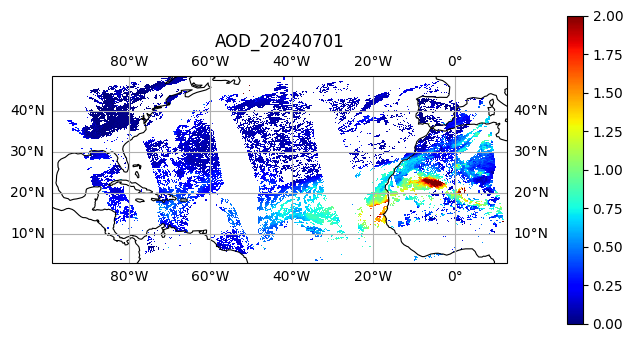

<Figure size 640x480 with 0 Axes>

In [37]:
    
plot_range = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
    
plot_l2_product(lons, lats, aods, plot_range=plot_range, label='', title=target_date.strftime('AOD_%Y%m%d'), vmin=0, vmax=2, fn=target_date.strftime('PACE_OCI_AOD_%Y%m%d.png'), cmap="jet")

# plot_l2_product(lon, lat,
# ssa_388_dt, plot_range=plot_range, label='', title='DT_SSA', vmin=0.7, vmax=1, 
#                 fn=target_date.strftime('PACE_OCI_DTSSA_%Y%m%d.png'), cmap="jet")

In [38]:
print(np.nanmean(aods))

0.2851784598124851


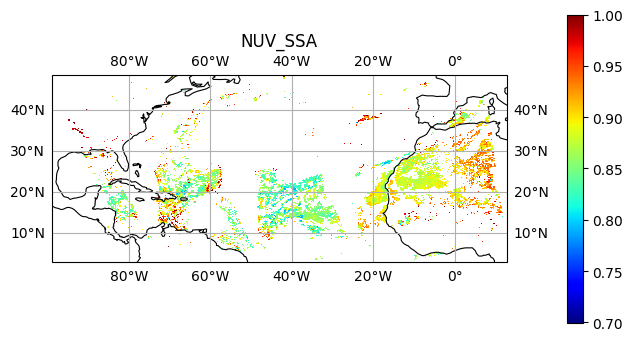

<Figure size 640x480 with 0 Axes>

In [14]:
plot_l2_product(lons, lats, ssas, plot_range=plot_range, label='', title='NUV_SSA', vmin=0.7, vmax=1, fn=target_date.strftime('PACE_OCI_NUVSSA_%Y%m%d.png'), cmap="jet")


In [41]:
#date range 
target_date_range = np.arange(datetime(2024,9,24), datetime(2024,10,10), timedelta(days=1)).astype(datetime)

In [43]:
daily_AOD_avg = []
for day in target_date_range:
    files = sorted(glob(oci_dir + day.strftime('*%Y%m%dT*'))) #should be 8 files/granules
    aods = []
    ssas = []
    lons = []
    lats = []

    for file in files:
        datatree = xr.open_datatree(file)
        dataset = xr.merge(datatree.to_dict().values())
        lon = np.array(dataset['longitude'])
        lat = np.array(dataset['latitude'])
        aod = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))
        ssa_388_dt = np.squeeze(np.array(dataset['DT_AerosolSingleScattAlbedo'][:,:,1]))
        ssa_388_nuv = np.squeeze(np.array(dataset['NUV_AerosolSingleScattAlbedo'][:,:,1]))
        
        lons.append(lon)
        lats.append(lat)
        aods.append(aod)
        ssas.append(ssa_388_nuv)
    daily_AOD_avg.append(np.nanmean(aods))

print(len(daily_AOD_avg))
        # daily_AOD_avg.append(np.nanmean(aods,axis = 0))
        # print(aod.shape)
        # print(np.nanmean(aod,axis = 0))

16


/tmp/ipykernel_3833/2562199598.py:22: RuntimeWarning: Mean of empty slice
  daily_AOD_avg.append(np.nanmean(aods))


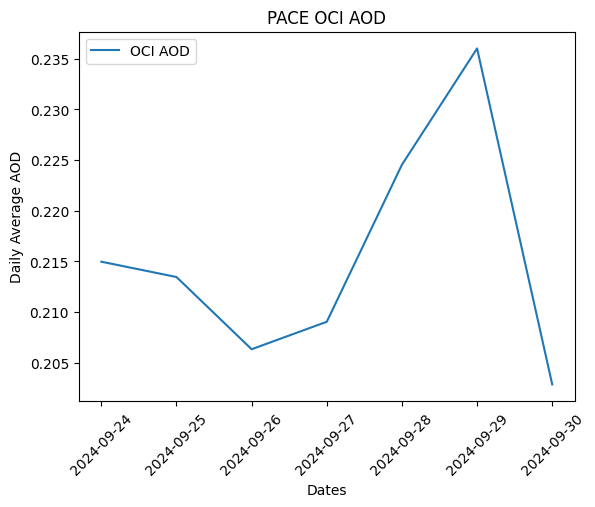

In [51]:
plt.plot(target_date_range,daily_AOD_avg, label = 'OCI AOD')
plt.ylabel('Daily Average AOD')
plt.xlabel('Dates')
plt.xticks(rotation = 45)
plt.title('PACE OCI AOD')
plt.legend()